### AOS 575 Application Lab 2 - aos575_applab2_AR1_regression_AO.ipynb
Written by Jennifer Kay (CU) and Elizabeth Maroon (CU); last updated Sept 23, 2020 <br>
Updated for AOS 575 by Elizabeth Maroon (UW), last updated Sept 29, 2020


#### Learning Goals

1. Calculate and analyze the autocorrelation at a range of lags using the observed Arctic Oscillation Index (itself output from an EOF analysis)
2. Generate red noise time series with the same memory (lag-1 autocorrelation) as the observed time series. 
3. Correlate two time series and calculate the statistical significance
4. Evaluate statistical significance when you provide many chances for success ("fishing" for correlations - recall the green jelly bean comic). 

#### Underlying Science and Data

This notebook loads in the monthly observed Arctic Oscillation (AO) index from 1950-present. This time series was itself generated using an Empirical Orthogonal Function (EOF) analysis of 1000 mb geopotential heights. You will implement EOF analysis in the next application lab, so this lab serves two purposes: applying what we've already learned in lecture and showing what is to come! <br> 

The AO index describes the amplitude of the EOF loading pattern, which can be found <a href="https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/loading.html"> here on NOAA CPC's website.</a>  When the AO index is positive and has a high magnitude, that month's 1000 mb geopotential heights project strongly (look a lot like) on to this pattern. When the AO index is negative but with a large negative, that month's 1000 mb heights project look like the negative of the EOF loading pattern.  If the AO index has a weak magnitude, then that month's heights don't look much like the pattern at all (i.e., they don't project strongly, or are nearly orthogonal). <br>

The AO index is one measure of the Northern Hemisphere's atmospheric circulation. By using an EOF method, the entire pattern of 1000mb heights is taken into account by this index, making it a more holistic measure of the atmospheric circulation than any single point or station-based indices. The AO is related to the North Atlantic Oscillation (NAO). Prof. Mike Wallace (UWash) like to use the analogy of Clark Kent and Superman for these two indices: different presentations of what is likely the same physical phenomenon. <br>

 <a href="http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii">NOAA rigorously calculates and updates the AO index here.</a> <br> This notebook uses the web to stream this dataset; it is also included in this folder.  <br>


Import packages here:

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
sns.set_style('whitegrid')  ###  change away from grey grid (seaborn default) to white grid

#### Helpful functions

Sometimes it is helpful to write a function if you are going to repeat the same set of code many times. Here is a snippet of code to create a red noise time series.  Feel free to expand the function.  Always double check functions: make sure that the code is doing what you think it should:

In [27]:
### red noise function
def ar1_series(a,N):   #a = alpha, lag1 autocorr; N = length of time series
    red_series = []
    red_series.append(1)
    for t in range(1,N,1):
        red_series.append(a*red_series[t-1] + np.sqrt(1-np.power(a,2))*stats.norm.rvs(size=1)) ##Barnes Ch. 2 Eq. 69
    return red_series

#### 1. Load in the data and inspect it.  

This notebook uses data from the Arctic Oscillation regularly updated by NOAA
For more information go here: http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/history/method.shtml <br>
Always plot your initial data. Look at it. Check that it makes sense!


   year  month        AO         time
0  1950      1 -0.060310  1950.041667
1  1950      2  0.626810  1950.125000
2  1950      3 -0.008128  1950.208333
3  1950      4  0.555100  1950.291667
4  1950      5  0.071577  1950.375000


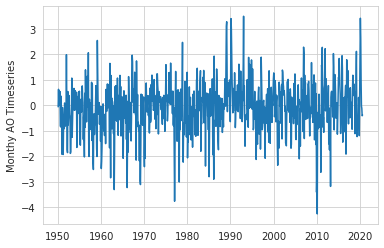

In [28]:
## Note this will not work if you do not have an internet connection as it is directly grabbing the data from the web.
data = pd.read_csv('http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii',\
                   sep='\s+',header=None, names = ['year', 'month','AO'])
## if not on-line
#data = pd.read_csv('monthly.ao.index.b50.current.ascii',\
#                   sep='\s+',header=None, names = ['year', 'month','AO'])

data['time']=data['year']+data['month']/12-1/24   #makes a time variabel from the year and month variables.
#print(data)
plt.plot(data['time'],data['AO'])
plt.savefig('AO_timeseries.png',dpi=300)  ## save your plot as a png. 
#Good habit to start: save pngs with high dpi (dots per inch). No one likes blurry figs!
plt.ylabel('Monthy AO Timeseries')
print(data.head());
data.tail();

Note that the above cell saved the figure (the savefig line). You should notice a "png" file appear in the panel at left. If you double click on the figure, you can look at it. <br>


#### 2. Calculate the lag-1 autocorrelation (AR1) of the AO data.

Use both np.correlate and the dot product methods. 

In [29]:
## Calculate the lag-one autocorrelation (AR1) of the AO data and print it to the screen
## Use two methods (np.correlate, dot products).  They should give you the same result.
time=data['time']
tseries=data['AO']
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
n=len(tseries)         ## calculate the length of the timeseries
lag=1

##Create two timeseries of the data at t=t1 and t=t2; remove the mean
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)  ## Eq. 67 divided by the variance
print('np.correlate autocorrelation: ',np.round(lagNauto_np,5))

#Method #2 (should be faster)
#Calculate the autocorrelation using np.dot (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Eq. 67 divided by the variance
print('direct calculation autocorrelation:',np.round(lagNauto,5))

if lag==1: ar1=lagNauto

np.correlate autocorrelation:  [0.31526]
direct calculation autocorrelation: 0.31526


Do both methods give the same result? What is the lag-1 autocorrelation? Interpret what the autocorrelation means. How much month-to-month memory (red noise) is there?

Your answer here

#### 3. Calculate and plot autocorrelation at all lags 

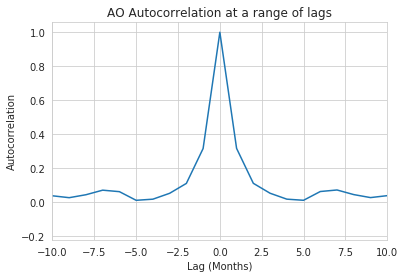

In [30]:
tseries1=tseries-mean
half=int(len(tseries)/2)
lags=np.arange(-1*half,half,1.)

plt.plot(range(-1*half,half),np.correlate(tseries1,tseries1,mode='same')/((n-lags)*sigma**2)) ##Eq. 2.67 divided by variance

plt.xlim([-10,10])
plt.xlabel('Lag (Months)');
plt.ylabel('Autocorrelation');
plt.title('AO Autocorrelation at a range of lags');

Describe your autocorrelation results. How red are the data at lags beyond one month? Is there any interesting behavior in the lags? At t=2 months, what would you have expected from a time series with the AR1 value that you found above?

Your answer here.

#### 4. Generate red noise time series that have the same lag-1 autocorrelation at the AO

Here, you are creating a synthetic dataset that has the same memory as the AO.

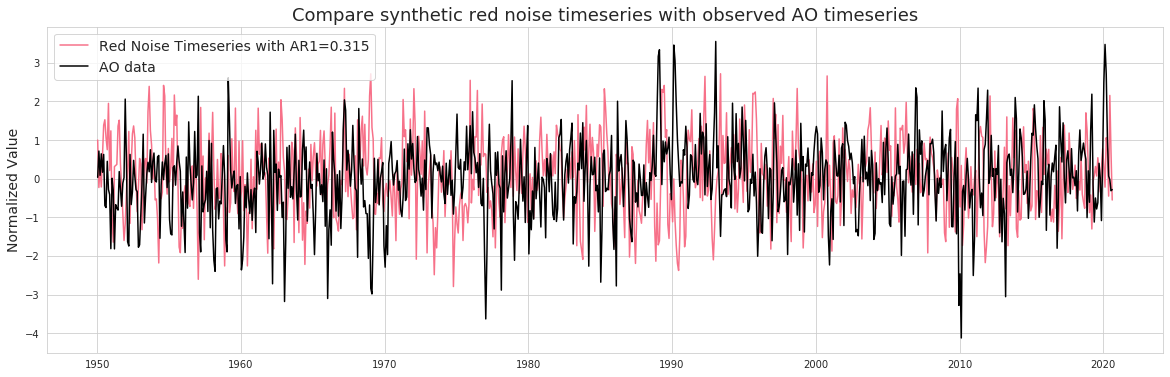

In [31]:
tsnum=1 ## how many red noise time series to generate
numred=len(time) ## length of red noise time series  ## setting to the same length at the observed AO time series
t_1=np.empty((tsnum,numred))
colors=sns.color_palette('husl',5) ##palette of 5 colors
f=plt.figure(figsize=(20,6))
for nn in range(tsnum):
    t_1[nn,:] = ar1_series(ar1,numred)
    plt.plot(time,t_1[nn,:],color=colors[nn],label='Red Noise Timeseries with AR1='+str(np.round(ar1,3)))

##Plot the two timeseries - the synthetic red noise and the actual data    
plt.plot(time,(tseries-tseries.mean())/tseries.std(),color='black',label='AO data');
plt.ylabel('Normalized Value',fontsize=14);
plt.title('Compare synthetic red noise timeseries with observed AO timeseries',fontsize=18);
plt.legend(loc='upper left',fontsize=14);

#### 5. What is the correlation between the synthetic red noise dataset and the actual AO data?  

In [32]:
### What is the correlation between the synthetic red noise and the actual AO data?
rednoise=t_1[0,:]
data=(tseries-tseries.mean())/tseries.std()
slope, intercept, r_value, p_value, std_err = stats.linregress(rednoise,data)
variance_explained_all=(r_value*r_value)*100.
print('What is percent variance explained?:',round(variance_explained_all,4),'%')

What is percent variance explained?: 1.1269 %


Do you expect there to be any correlation between these two time series? Why or why not?

Your answer here

#### 6. Fishing for correlations
What happens if you repeat the above calculation and try correlating many, many red noise time series against the real AO index. Can you get a higher variance explained ($R^2$ value)? <br>

Note: you are effectively searching for a high correlation with no a priori reason to do so.... <br> 
<b>THIS IS NOT good practice for science </b> (remember the green jelly beans?) but is instructive to see the results here. :)

In [33]:
largest_variance=0  #initial value to start with
largest_r=0
nn_largest_variance=0
length=20   #size of the AO subset to use
offset=3    #index to start at for AO and synthetic data
N_fishingforcorrelation=200 ## number of times you will go "fishing for correlations"

for nn in range(N_fishingforcorrelation):
    subset_rednoise=rednoise[nn*offset:nn*offset+length]  #grab a segment of red noise time series
    subset_data=data[nn*offset:nn*offset+length]          #grab a subset of the AO time series
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset_rednoise,subset_data) #correlate the two segments
    variance_explained=(r_value*r_value)*100.
    
    if variance_explained > largest_variance:   #if new correlation is new max, replace in this if-statement
        largest_variance=variance_explained
        largest_r=r_value
        nn_largest_variance=nn
    
print('nn_largest_variance',nn_largest_variance)
print('Largest r_value',round(largest_r,2))        
print('Largest variance explained',round(largest_variance,2),'%')

nn_largest_variance 172
Largest r_value -0.53
Largest variance explained 27.74 %


You were searching for correlations, You searched long and hard (200 times!). You might expect that the largest correlation you found will be a false positive.  Is it?  Did your "fishing" for a high correlation work?

Your answer here

Here the two segments of real AO and synthetic red noise time with highest correlation are plotted. Do they look correlated to you?

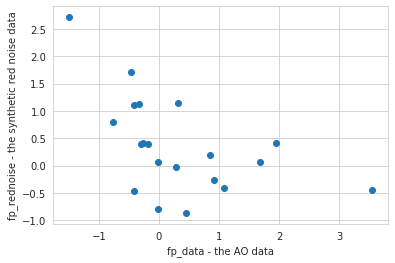

In [34]:
## Plotting 
## data chunks with the largest correlation
fp_rednoise=rednoise[nn_largest_variance*offset:nn_largest_variance*offset+length]
fp_data=data[nn_largest_variance*offset:nn_largest_variance*offset+length]

## make a scatter plot - Do you see a correlation?
plt.scatter(fp_data,fp_rednoise);   
plt.xlabel('fp_data - the AO data');
plt.ylabel('fp_rednoise - the synthetic red noise data');

#### 7. Calculate correlation statistics for your highest correlation 
Two methods are shown - they should give you the same answers.

In [35]:
### Calculate the correlation statistics - slow way, but convenient
slope, intercept, r_value, p_value, std_err = stats.linregress(fp_rednoise,fp_data)
print('scipy.stats.linregress slope: ',round(slope,3))
print('scipy.stats.linregress intercept: ',round(intercept,3))
print('scipy.stats.linregress r_value: ',round(r_value,3))
print()

### Calculate the correlation statistics - direct and fast way
### for reference, answers should be the same...
### Shows direct calculation using Barnes notes
xdata=fp_rednoise-np.mean(fp_rednoise)
ydata=fp_data-np.mean(fp_data)
variancex=np.sum((xdata*xdata))
covariance=np.dot(xdata,ydata)
slope_fast=covariance/variancex                          ##Barnes Chapter 2, Eq. (14)
intercept_fast=np.mean(fp_data)-slope_fast*np.mean(fp_rednoise)  ##Barnes Chapter 2, Eq. (15)
variancey=np.sum((ydata*ydata))
rvalue_fast=np.dot(xdata,ydata)/(np.sqrt(variancex)*np.sqrt(variancey)) ##Barnes Chapter 2, Eq. (31)
print('direct method slope_fast: ',round(slope_fast,3))
print('direct method intercept_fast: ',round(intercept_fast,3))
print('direct method rvalue_fast: ',round(rvalue_fast,3))

scipy.stats.linregress slope:  -0.67
scipy.stats.linregress intercept:  0.567
scipy.stats.linregress r_value:  -0.527

direct method slope_fast:  -0.67
direct method intercept_fast:  0.567
direct method rvalue_fast:  -0.527


Place a confidence interval on your correlation. Because you have found a correlation that is not equal to 0, use the Fisher-Z Transformation.

In [36]:
## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
#print('mu_Z:',mu_Z)
df=len(fp_data)-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53

## Calculate the critical value, i.e., the t-statistic
## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
#print('Zmin',Zmin)
#print('Zmax',Zmax)

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for r_value):',round(rho_max,2))

## 

Rhomin (minimum 95% confidence interval for r_value): -0.8
Rhomax (maximum 95% confidence interval for r_value): -0.07


If the confidence range for the true correlation given by Rhomin,Rhomax does not overlap with 0 - we can reject the null hypothesis that the correlation between fp_data and fp_rednoise is zero. If we reject the null hypothesis that the correlation is zero, we have found a false positive!

Have you found a false positive by chance?

#### 8. Assessing the statistical and physical meaning of the above fishing exercise.

Remember the green jelly bean example and Arctic warming blocking example in Barnes Chapter 1 applying a posteriori statistics? How likely was it that you would correctly reject H0 for all of the correlations you explored?   In other words - How likely are you to be correct in all of your assessments? You should find it is very unlikely... and this should make you wary of doing anything like what we were doing above when analyzing data and looking for correlations. Be skeptical as you analyze data! Don't be tricked into seeing what you expect to see by chance.

In [37]:
#same math as the green jelly bean example
prob_correctly_rejecting_all=(0.95**N_fishingforcorrelation)*100
print('prob_correctly_rejecting_all',round(prob_correctly_rejecting_all,4),'%')

prob_correctly_rejecting_all 0.0035 %


What lessons have you learned from "fishing for correlations"?

Your answer here